<a href="https://colab.research.google.com/github/HernanJMaurice/androidSensors/blob/main/HPC/Ejercicio_2_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_primer_imagen = "https://github.com/HernanJMaurice/androidSensors/blob/main/HPC/imagenes/image2.jpeg?raw=true" #@param {type:"string"}
url_segunda_imagen = "https://github.com/HernanJMaurice/androidSensors/blob/main/HPC/imagenes/image5.jpeg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_primer_imagen} -O imagen1.jpeg
!wget {url_segunda_imagen} -O imagen2.jpeg

--2020-11-16 20:57:01--  https://github.com/HernanJMaurice/androidSensors/blob/main/HPC/imagenes/image2.jpeg?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/HernanJMaurice/androidSensors/raw/main/HPC/imagenes/image2.jpeg [following]
--2020-11-16 20:57:02--  https://github.com/HernanJMaurice/androidSensors/raw/main/HPC/imagenes/image2.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HernanJMaurice/androidSensors/main/HPC/imagenes/image2.jpeg [following]
--2020-11-16 20:57:02--  https://raw.githubusercontent.com/HernanJMaurice/androidSensors/main/HPC/imagenes/image2.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.git

In [ ]:
!pip install pycuda

Imagen del filtro: imagen2.jpeg -RGB- [960, 1280]
Thread: [ 16 , 19  ], Bloque : [ 60 , 68 ]
Total de Thread: [ 960 , 1292  ]  =  1240320
Tiempo TOTAL:  123.006 [ms]
Tiempo GPU  :  0.366 [ms]


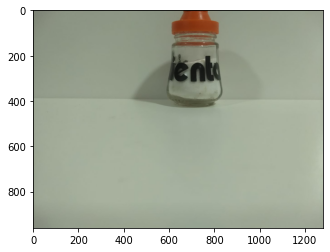

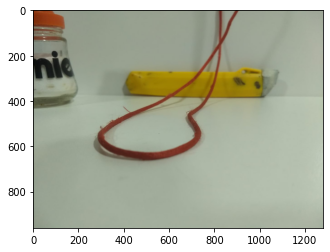

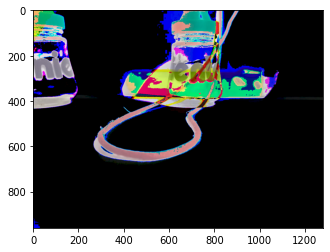

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

#---------------------------------------------
#           Primera Imagen
#---------------------------------------------

img_nombre = 'imagen1.jpeg'
image1 = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img1_alto, img1_ancho = image1.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img1_origen_cpu = numpy.asarray(image1)

# Reservo el vector en GPU
img1_origen_gpu = cuda.mem_alloc( img1_origen_cpu.nbytes )

#---------------------------------------------
#           Segunda Imagen
#---------------------------------------------

img_nombre = 'imagen2.jpeg'
image2 = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img2_alto, img2_ancho = image2.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img2_origen_cpu = numpy.asarray(image2)

# Reservo el vector en GPU
img2_origen_gpu = cuda.mem_alloc( img2_origen_cpu.nbytes )

#---------------------------------------------
#           Imagen Resultado
#---------------------------------------------

#Creo un array vacio
img_resultado_cpu = numpy.empty_like( img1_origen_cpu )

img_resultado_gpu = cuda.mem_alloc( img_resultado_cpu.nbytes )


# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img1_origen_gpu, img1_origen_cpu )
cuda.memcpy_htod( img2_origen_gpu, img2_origen_cpu )
cuda.memcpy_htod( img_resultado_gpu, img_resultado_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_o, char *img2_o, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fGris = 0.0;
  float px1_r, px2_r, px1_g, px2_g, px1_b, px2_b, pr, pb , pg;
  float umbral_diferencia = 20;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
      px1_r = (float) img_o[(idx+(idy*ancho))*3    ];
      px2_r = (float) img2_o[(idx+(idy*ancho))*3    ];

      px1_g = (float) img_o[((idx+(idy*ancho))*3)+1];
      px2_g = (float) img2_o[((idx+(idy*ancho))*3)+1];

      px1_b = (float) img_o[((idx+(idy*ancho))*3)+2];
      px2_b = (float) img2_o[((idx+(idy*ancho))*3)+2];


      if ( px2_r > px1_r)
      {
        pr = px2_r - px1_r;
      }else
      {
        pr = px1_r - px2_r;
      } 


      if ( px2_g > px1_g)
      {
        pg = px2_g - px1_g;
      }else
      {
        pg = px1_g - px2_g;
      } 


      if ( px2_b > px1_b)
      {
        pb = px2_b - px1_b;
      }else
      {
        pb = px1_b - px2_b;
      } 
      

      if(pr < umbral_diferencia)
      {
        pr = 0;
      }

      if(pg < umbral_diferencia)
      {
        pg = 0;
      }

      if(pb < umbral_diferencia)
      {
        pb = 0;
      }

      // Escribo el color del pixel.
      img_R[(idx+(idy*ancho))*3  ] = (char) pr;
      img_R[((idx+(idy*ancho))*3)+1] = (char) pg;
      img_R[((idx+(idy*ancho))*3)+2] = (char) pb;
  }
}
""") 


# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image1.mode + "- [" + str(img1_ancho) + ", " + str(img1_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img1_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img1_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img1_ancho), numpy.int32(img1_alto), img1_origen_gpu, img2_origen_gpu, img_resultado_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_resultado_cpu, img_resultado_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img1_origen_cpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img2_origen_cpu )


# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_resultado_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )
